# ELL793 Assignment 4
**Object Detection mAP scores and Plots** <br>
Abhinava Sikdar 2017MT01724 <br>
Yashank Singh 2017MT10756

In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

print('Is CUDA available', torch.cuda.is_available())
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))
#https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

Is CUDA available True
Torch 1.7.0+cu101 CUDA 10.1
Device: cuda:0


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#https://colab.research.google.com/github/pytorch/vision/blob/temp-tutorial/tutorials/torchvision_finetuning_instance_segmentation.ipynb#scrollTo=-WXLwePV5ieP
!git clone https://github.com/pytorch/vision.git
!cd vision
!git checkout v0.3.0

!cp /content/vision/references/detection/utils.py ../usr/lib/python3.6
!cp /content/vision/references/detection/transforms.py ../usr/lib/python3.6
!cp /content/vision/references/detection/coco_eval.py ../usr/lib/python3.6
!cp /content/vision/references/detection/engine.py ../usr/lib/python3.6
!cp /content/vision/references/detection/coco_utils.py ../usr/lib/python3.6

Cloning into 'vision'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 12255 (delta 2), reused 1 (delta 0), pack-reused 12249
Receiving objects: 100% (12255/12255), 13.46 MiB | 23.49 MiB/s, done.
Resolving deltas: 100% (8555/8555), done.
fatal: not a git repository (or any of the parent directories): .git


In [4]:
dev=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
#https://github.com/pytorch/vision/blob/master/references/detection/engine.py
#https://github.com/pytorch/vision/blob/master/references/detection/utils.py
from engine import evaluate,train_one_epoch
import utils
import transforms as T

## Datset and Loaders

In [14]:
def return_class(class_name):
    classes=['person','bird', 'cat', 'cow', 'dog', 'horse', 'sheep', 'aeroplane', 'bicycle', 'boat', 'bus', 'car', 'motorbike', 'train', 'bottle', 'chair', 'diningtable', 'pottedplant', 'sofa', 'tvmonitor']
    return classes.index(class_name)

In [15]:
class VOC_Dataset(torch.utils.data.Dataset):
  def __init__(self, dataset, transforms=None):
    self.transforms = transforms
    self.dataset=dataset
  
  def __getitem__(self,ind):
    boxes=[]
    names=[]
    img,dic =self.dataset[ind]
    for i in range(len(dic['annotation']['object'])):
      xmax=int(dic['annotation']['object'][i]['bndbox']['xmax'])
      xmin=int(dic['annotation']['object'][i]['bndbox']['xmin'])
      ymax=int(dic['annotation']['object'][i]['bndbox']['ymax'])
      ymin=int(dic['annotation']['object'][i]['bndbox']['ymin'])
      boxes.append([xmin, ymin, xmax, ymax])
      names.append(return_class(dic['annotation']['object'][i]['name']))
    
    target={}
    target['boxes']=torch.as_tensor(boxes,dtype=torch.float32)
    target['labels']=torch.as_tensor(names,dtype=torch.int64)
    target['image_id'] = torch.tensor(int(dic['annotation']['source']['flickrid']),dtype=torch.int64)
    target['area']=(target['boxes'][:, 3] - target['boxes'][:, 1]) * (target['boxes'][:, 2] - target['boxes'][:, 0])
    target['iscrowd']=torch.zeros((len(dic['annotation']['object']),), dtype=torch.int64)
    return img,target

  def __len__(self):
    return len(self.dataset)

In [16]:
data_path='../data/'
voc_train_tem=datasets.VOCDetection(data_path, year='2007', image_set='train', download=True, transform=transforms.ToTensor())
voc_test_tem=datasets.VOCDetection(data_path, year='2007', image_set='trainval',download=True, transform=transforms.ToTensor())

Using downloaded and verified file: ../data/VOCtrainval_06-Nov-2007.tar
Using downloaded and verified file: ../data/VOCtrainval_06-Nov-2007.tar


In [17]:
voc_train=VOC_Dataset(dataset=voc_train_tem)
voc_test=VOC_Dataset(dataset=voc_test_tem)

5011


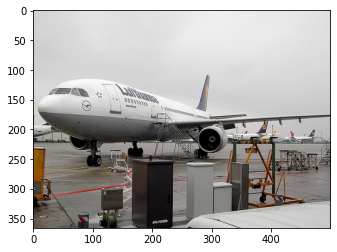

In [18]:
print(len(voc_test))
img,lab=voc_test_tem[14]
plt.imshow(img.permute(1,2,0))

In [19]:
train_loader=torch.utils.data.DataLoader(voc_train,batch_size=1,shuffle=False, num_workers=0,collate_fn=utils.collate_fn)
test_loader=torch.utils.data.DataLoader(voc_test,batch_size=1,shuffle=False, num_workers=0,collate_fn=utils.collate_fn)

# Load Saved Faster-RCNN Model

In [ ]:
model = torch.load('/content/gdrive/MyDrive/model19.pth')
model=model.to(dev)
model.eval()

# Load Saved RetinaNet Model

In [58]:
model = torch.load('/content/gdrive/MyDrive/RetinaNet58.pth')
model=model.to(dev)
model.eval()

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256)
          )
        )
        (1): Bottleneck

# Load Saved RetinaNet_CEloss Model

## Model

In [29]:
import torch
import torch.nn.functional as F


def ce_loss(
    inputs,
    targets,
    reduction: str = "none",
):
    """
    Original implementation from https://github.com/facebookresearch/fvcore/blob/master/fvcore/nn/focal_loss.py .
    Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.
    Args:
        inputs: A float tensor of arbitrary shape.
                The predictions for each example.
        targets: A float tensor with the same shape as inputs. Stores the binary
                 classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
        reduction: 'none' | 'mean' | 'sum'
                 'none': No reduction will be applied to the output.
                 'mean': The output will be averaged.
                 'sum': The output will be summed.
    Returns:
        Loss tensor with the reduction option applied.
    """
    p = torch.sigmoid(inputs)
    ce_loss = F.binary_cross_entropy_with_logits(
        inputs, targets, reduction="none"
    )
    loss = ce_loss
    if reduction == "mean":
        loss = loss.mean()
    elif reduction == "sum":
        loss = loss.sum()

    return loss

In [30]:
import math
from collections import OrderedDict
import warnings

import torch
import torch.nn as nn
from torch import Tensor
from torch.jit.annotations import Dict, List, Tuple

from torchvision.models.utils import load_state_dict_from_url

from torchvision.models.detection import _utils as det_utils
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.ops.feature_pyramid_network import LastLevelP6P7
from torchvision.ops import boxes as box_ops


__all__ = [
    "RetinaNet", "retinanet_resnet50_fpn",
]


def _sum(x: List[Tensor]) -> Tensor:
    res = x[0]
    for i in x[1:]:
        res = res + i
    return res


class RetinaNetHead(nn.Module):
    """
    A regression and classification head for use in RetinaNet.

    Arguments:
        in_channels (int): number of channels of the input feature
        num_anchors (int): number of anchors to be predicted
        num_classes (int): number of classes to be predicted
    """

    def __init__(self, in_channels, num_anchors, num_classes):
        super().__init__()
        self.classification_head = RetinaNetClassificationHead(in_channels, num_anchors, num_classes)
        self.regression_head = RetinaNetRegressionHead(in_channels, num_anchors)

    def compute_loss(self, targets, head_outputs, anchors, matched_idxs):
        # type: (List[Dict[str, Tensor]], Dict[str, Tensor], List[Tensor], List[Tensor]) -> Dict[str, Tensor]
        return {
            'classification': self.classification_head.compute_loss(targets, head_outputs, matched_idxs),
            'bbox_regression': self.regression_head.compute_loss(targets, head_outputs, anchors, matched_idxs),
        }

    def forward(self, x):
        # type: (List[Tensor]) -> Dict[str, Tensor]
        return {
            'cls_logits': self.classification_head(x),
            'bbox_regression': self.regression_head(x)
        }


class RetinaNetClassificationHead(nn.Module):
    """
    A classification head for use in RetinaNet.

    Arguments:
        in_channels (int): number of channels of the input feature
        num_anchors (int): number of anchors to be predicted
        num_classes (int): number of classes to be predicted
    """

    def __init__(self, in_channels, num_anchors, num_classes, prior_probability=0.01):
        super().__init__()

        conv = []
        for _ in range(4):
            conv.append(nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1))
            conv.append(nn.ReLU())
        self.conv = nn.Sequential(*conv)

        for layer in self.conv.children():
            if isinstance(layer, nn.Conv2d):
                torch.nn.init.normal_(layer.weight, std=0.01)
                torch.nn.init.constant_(layer.bias, 0)

        self.cls_logits = nn.Conv2d(in_channels, num_anchors * num_classes, kernel_size=3, stride=1, padding=1)
        torch.nn.init.normal_(self.cls_logits.weight, std=0.01)
        torch.nn.init.constant_(self.cls_logits.bias, -math.log((1 - prior_probability) / prior_probability))

        self.num_classes = num_classes
        self.num_anchors = num_anchors

        # This is to fix using det_utils.Matcher.BETWEEN_THRESHOLDS in TorchScript.
        # TorchScript doesn't support class attributes.
        # https://github.com/pytorch/vision/pull/1697#issuecomment-630255584
        self.BETWEEN_THRESHOLDS = det_utils.Matcher.BETWEEN_THRESHOLDS

    def compute_loss(self, targets, head_outputs, matched_idxs):
        # type: (List[Dict[str, Tensor]], Dict[str, Tensor], List[Tensor]) -> Tensor
        losses = []

        cls_logits = head_outputs['cls_logits']

        for targets_per_image, cls_logits_per_image, matched_idxs_per_image in zip(targets, cls_logits, matched_idxs):
            # determine only the foreground
            foreground_idxs_per_image = matched_idxs_per_image >= 0
            num_foreground = foreground_idxs_per_image.sum()
            # no matched_idxs means there were no annotations in this image
            # TODO: enable support for images without annotations that works on distributed
            if False:  # matched_idxs_per_image.numel() == 0:
                gt_classes_target = torch.zeros_like(cls_logits_per_image)
                valid_idxs_per_image = torch.arange(cls_logits_per_image.shape[0])
            else:
                # create the target classification
                gt_classes_target = torch.zeros_like(cls_logits_per_image)
                gt_classes_target[
                    foreground_idxs_per_image,
                    targets_per_image['labels'][matched_idxs_per_image[foreground_idxs_per_image]]
                ] = 1.0

                # find indices for which anchors should be ignored
                valid_idxs_per_image = matched_idxs_per_image != self.BETWEEN_THRESHOLDS

            # compute the classification loss################################################CHANGES START HERE##################################################################################################
            losses.append(ce_loss(
                cls_logits_per_image[valid_idxs_per_image],
                gt_classes_target[valid_idxs_per_image],
                reduction='sum',
            ) / max(1, num_foreground))
            # compute the classification loss################################################CHANGES END HERE##################################################################################################

        return _sum(losses) / len(targets)

    def forward(self, x):
        # type: (List[Tensor]) -> Tensor
        all_cls_logits = []

        for features in x:
            cls_logits = self.conv(features)
            cls_logits = self.cls_logits(cls_logits)

            # Permute classification output from (N, A * K, H, W) to (N, HWA, K).
            N, _, H, W = cls_logits.shape
            cls_logits = cls_logits.view(N, -1, self.num_classes, H, W)
            cls_logits = cls_logits.permute(0, 3, 4, 1, 2)
            cls_logits = cls_logits.reshape(N, -1, self.num_classes)  # Size=(N, HWA, 4)

            all_cls_logits.append(cls_logits)

        return torch.cat(all_cls_logits, dim=1)


class RetinaNetRegressionHead(nn.Module):
    """
    A regression head for use in RetinaNet.

    Arguments:
        in_channels (int): number of channels of the input feature
        num_anchors (int): number of anchors to be predicted
    """
    __annotations__ = {
        'box_coder': det_utils.BoxCoder,
    }

    def __init__(self, in_channels, num_anchors):
        super().__init__()

        conv = []
        for _ in range(4):
            conv.append(nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1))
            conv.append(nn.ReLU())
        self.conv = nn.Sequential(*conv)

        self.bbox_reg = nn.Conv2d(in_channels, num_anchors * 4, kernel_size=3, stride=1, padding=1)
        torch.nn.init.normal_(self.bbox_reg.weight, std=0.01)
        torch.nn.init.zeros_(self.bbox_reg.bias)

        for layer in self.conv.children():
            if isinstance(layer, nn.Conv2d):
                torch.nn.init.normal_(layer.weight, std=0.01)
                torch.nn.init.zeros_(layer.bias)

        self.box_coder = det_utils.BoxCoder(weights=(1.0, 1.0, 1.0, 1.0))

    def compute_loss(self, targets, head_outputs, anchors, matched_idxs):
        # type: (List[Dict[str, Tensor]], Dict[str, Tensor], List[Tensor], List[Tensor]) -> Tensor
        losses = []

        bbox_regression = head_outputs['bbox_regression']

        for targets_per_image, bbox_regression_per_image, anchors_per_image, matched_idxs_per_image in \
                zip(targets, bbox_regression, anchors, matched_idxs):
            # no matched_idxs means there were no annotations in this image
            # TODO enable support for images without annotations with distributed support
            # if matched_idxs_per_image.numel() == 0:
            #     continue

            # get the targets corresponding GT for each proposal
            # NB: need to clamp the indices because we can have a single
            # GT in the image, and matched_idxs can be -2, which goes
            # out of bounds
            matched_gt_boxes_per_image = targets_per_image['boxes'][matched_idxs_per_image.clamp(min=0)]

            # determine only the foreground indices, ignore the rest
            foreground_idxs_per_image = matched_idxs_per_image >= 0
            num_foreground = foreground_idxs_per_image.sum()

            # select only the foreground boxes
            matched_gt_boxes_per_image = matched_gt_boxes_per_image[foreground_idxs_per_image, :]
            bbox_regression_per_image = bbox_regression_per_image[foreground_idxs_per_image, :]
            anchors_per_image = anchors_per_image[foreground_idxs_per_image, :]

            # compute the regression targets
            target_regression = self.box_coder.encode_single(matched_gt_boxes_per_image, anchors_per_image)

            # compute the loss
            losses.append(torch.nn.functional.l1_loss(
                bbox_regression_per_image,
                target_regression,
                size_average=False
            ) / max(1, num_foreground))

        return _sum(losses) / max(1, len(targets))

    def forward(self, x):
        # type: (List[Tensor]) -> Tensor
        all_bbox_regression = []

        for features in x:
            bbox_regression = self.conv(features)
            bbox_regression = self.bbox_reg(bbox_regression)

            # Permute bbox regression output from (N, 4 * A, H, W) to (N, HWA, 4).
            N, _, H, W = bbox_regression.shape
            bbox_regression = bbox_regression.view(N, -1, 4, H, W)
            bbox_regression = bbox_regression.permute(0, 3, 4, 1, 2)
            bbox_regression = bbox_regression.reshape(N, -1, 4)  # Size=(N, HWA, 4)

            all_bbox_regression.append(bbox_regression)

        return torch.cat(all_bbox_regression, dim=1)


class RetinaNet(nn.Module):
    """
    Implements RetinaNet.

    The input to the model is expected to be a list of tensors, each of shape [C, H, W], one for each
    image, and should be in 0-1 range. Different images can have different sizes.

    The behavior of the model changes depending if it is in training or evaluation mode.

    During training, the model expects both the input tensors, as well as a targets (list of dictionary),
    containing:
        - boxes (FloatTensor[N, 4]): the ground-truth boxes in [x1, y1, x2, y2] format, with values
          between 0 and H and 0 and W
        - labels (Int64Tensor[N]): the class label for each ground-truth box

    The model returns a Dict[Tensor] during training, containing the classification and regression
    losses.

    During inference, the model requires only the input tensors, and returns the post-processed
    predictions as a List[Dict[Tensor]], one for each input image. The fields of the Dict are as
    follows:
        - boxes (FloatTensor[N, 4]): the predicted boxes in [x1, y1, x2, y2] format, with values between
          0 and H and 0 and W
        - labels (Int64Tensor[N]): the predicted labels for each image
        - scores (Tensor[N]): the scores for each prediction

    Arguments:
        backbone (nn.Module): the network used to compute the features for the model.
            It should contain an out_channels attribute, which indicates the number of output
            channels that each feature map has (and it should be the same for all feature maps).
            The backbone should return a single Tensor or an OrderedDict[Tensor].
        num_classes (int): number of output classes of the model (excluding the background).
        min_size (int): minimum size of the image to be rescaled before feeding it to the backbone
        max_size (int): maximum size of the image to be rescaled before feeding it to the backbone
        image_mean (Tuple[float, float, float]): mean values used for input normalization.
            They are generally the mean values of the dataset on which the backbone has been trained
            on
        image_std (Tuple[float, float, float]): std values used for input normalization.
            They are generally the std values of the dataset on which the backbone has been trained on
        anchor_generator (AnchorGenerator): module that generates the anchors for a set of feature
            maps.
        head (nn.Module): Module run on top of the feature pyramid.
            Defaults to a module containing a classification and regression module.
        score_thresh (float): Score threshold used for postprocessing the detections.
        nms_thresh (float): NMS threshold used for postprocessing the detections.
        detections_per_img (int): Number of best detections to keep after NMS.
        fg_iou_thresh (float): minimum IoU between the anchor and the GT box so that they can be
            considered as positive during training.
        bg_iou_thresh (float): maximum IoU between the anchor and the GT box so that they can be
            considered as negative during training.

    Example:

        >>> import torch
        >>> import torchvision
        >>> from torchvision.models.detection import RetinaNet
        >>> from torchvision.models.detection.anchor_utils import AnchorGenerator
        >>> # load a pre-trained model for classification and return
        >>> # only the features
        >>> backbone = torchvision.models.mobilenet_v2(pretrained=True).features
        >>> # RetinaNet needs to know the number of
        >>> # output channels in a backbone. For mobilenet_v2, it's 1280
        >>> # so we need to add it here
        >>> backbone.out_channels = 1280
        >>>
        >>> # let's make the network generate 5 x 3 anchors per spatial
        >>> # location, with 5 different sizes and 3 different aspect
        >>> # ratios. We have a Tuple[Tuple[int]] because each feature
        >>> # map could potentially have different sizes and
        >>> # aspect ratios
        >>> anchor_generator = AnchorGenerator(
        >>>     sizes=((32, 64, 128, 256, 512),),
        >>>     aspect_ratios=((0.5, 1.0, 2.0),)
        >>> )
        >>>
        >>> # put the pieces together inside a RetinaNet model
        >>> model = RetinaNet(backbone,
        >>>                   num_classes=2,
        >>>                   anchor_generator=anchor_generator)
        >>> model.eval()
        >>> x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
        >>> predictions = model(x)
    """
    __annotations__ = {
        'box_coder': det_utils.BoxCoder,
        'proposal_matcher': det_utils.Matcher,
    }

    def __init__(self, backbone, num_classes,
                 # transform parameters
                 min_size=800, max_size=1333,
                 image_mean=None, image_std=None,
                 # Anchor parameters
                 anchor_generator=None, head=None,
                 proposal_matcher=None,
                 score_thresh=0.05,
                 nms_thresh=0.5,
                 detections_per_img=300,
                 fg_iou_thresh=0.5, bg_iou_thresh=0.4):
        super().__init__()

        if not hasattr(backbone, "out_channels"):
            raise ValueError(
                "backbone should contain an attribute out_channels "
                "specifying the number of output channels (assumed to be the "
                "same for all the levels)")
        self.backbone = backbone

        assert isinstance(anchor_generator, (AnchorGenerator, type(None)))

        if anchor_generator is None:
            anchor_sizes = tuple((x, int(x * 2 ** (1.0 / 3)), int(x * 2 ** (2.0 / 3))) for x in [32, 64, 128, 256, 512])
            aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
            anchor_generator = AnchorGenerator(
                anchor_sizes, aspect_ratios
            )
        self.anchor_generator = anchor_generator

        if head is None:
            head = RetinaNetHead(backbone.out_channels, anchor_generator.num_anchors_per_location()[0], num_classes)
        self.head = head

        if proposal_matcher is None:
            proposal_matcher = det_utils.Matcher(
                fg_iou_thresh,
                bg_iou_thresh,
                allow_low_quality_matches=True,
            )
        self.proposal_matcher = proposal_matcher

        self.box_coder = det_utils.BoxCoder(weights=(1.0, 1.0, 1.0, 1.0))

        if image_mean is None:
            image_mean = [0.485, 0.456, 0.406]
        if image_std is None:
            image_std = [0.229, 0.224, 0.225]
        self.transform = GeneralizedRCNNTransform(min_size, max_size, image_mean, image_std)

        self.score_thresh = score_thresh
        self.nms_thresh = nms_thresh
        self.detections_per_img = detections_per_img

        # used only on torchscript mode
        self._has_warned = False

    @torch.jit.unused
    def eager_outputs(self, losses, detections):
        # type: (Dict[str, Tensor], List[Dict[str, Tensor]]) -> Tuple[Dict[str, Tensor], List[Dict[str, Tensor]]]
        if self.training:
            return losses

        return detections

    def compute_loss(self, targets, head_outputs, anchors):
        # type: (List[Dict[str, Tensor]], Dict[str, Tensor], List[Tensor]) -> Dict[str, Tensor]
        matched_idxs = []
        for anchors_per_image, targets_per_image in zip(anchors, targets):
            if targets_per_image['boxes'].numel() == 0:
                matched_idxs.append(torch.empty((0,), dtype=torch.int32))
                continue

            match_quality_matrix = box_ops.box_iou(targets_per_image['boxes'], anchors_per_image)
            matched_idxs.append(self.proposal_matcher(match_quality_matrix))

        return self.head.compute_loss(targets, head_outputs, anchors, matched_idxs)

    def postprocess_detections(self, head_outputs, anchors, image_shapes):
        # type: (Dict[str, Tensor], List[Tensor], List[Tuple[int, int]]) -> List[Dict[str, Tensor]]
        # TODO: Merge this with roi_heads.RoIHeads.postprocess_detections ?

        class_logits = head_outputs.pop('cls_logits')
        box_regression = head_outputs.pop('bbox_regression')
        other_outputs = head_outputs

        device = class_logits.device
        num_classes = class_logits.shape[-1]

        scores = torch.sigmoid(class_logits)

        # create labels for each score
        labels = torch.arange(num_classes, device=device)
        labels = labels.view(1, -1).expand_as(scores)

        detections = torch.jit.annotate(List[Dict[str, Tensor]], [])

        for index, (box_regression_per_image, scores_per_image, labels_per_image, anchors_per_image, image_shape) in \
                enumerate(zip(box_regression, scores, labels, anchors, image_shapes)):

            boxes_per_image = self.box_coder.decode_single(box_regression_per_image, anchors_per_image)
            boxes_per_image = box_ops.clip_boxes_to_image(boxes_per_image, image_shape)

            other_outputs_per_image = [(k, v[index]) for k, v in other_outputs.items()]

            image_boxes = []
            image_scores = []
            image_labels = []
            image_other_outputs = torch.jit.annotate(Dict[str, List[Tensor]], {})

            for class_index in range(num_classes):
                # remove low scoring boxes
                inds = torch.gt(scores_per_image[:, class_index], self.score_thresh)
                boxes_per_class, scores_per_class, labels_per_class = \
                    boxes_per_image[inds], scores_per_image[inds, class_index], labels_per_image[inds, class_index]
                other_outputs_per_class = [(k, v[inds]) for k, v in other_outputs_per_image]

                # remove empty boxes
                keep = box_ops.remove_small_boxes(boxes_per_class, min_size=1e-2)
                boxes_per_class, scores_per_class, labels_per_class = \
                    boxes_per_class[keep], scores_per_class[keep], labels_per_class[keep]
                other_outputs_per_class = [(k, v[keep]) for k, v in other_outputs_per_class]

                # non-maximum suppression, independently done per class
                keep = box_ops.nms(boxes_per_class, scores_per_class, self.nms_thresh)

                # keep only topk scoring predictions
                keep = keep[:self.detections_per_img]
                boxes_per_class, scores_per_class, labels_per_class = \
                    boxes_per_class[keep], scores_per_class[keep], labels_per_class[keep]
                other_outputs_per_class = [(k, v[keep]) for k, v in other_outputs_per_class]

                image_boxes.append(boxes_per_class)
                image_scores.append(scores_per_class)
                image_labels.append(labels_per_class)

                for k, v in other_outputs_per_class:
                    if k not in image_other_outputs:
                        image_other_outputs[k] = []
                    image_other_outputs[k].append(v)

            detections.append({
                'boxes': torch.cat(image_boxes, dim=0),
                'scores': torch.cat(image_scores, dim=0),
                'labels': torch.cat(image_labels, dim=0),
            })

            for k, v in image_other_outputs.items():
                detections[-1].update({k: torch.cat(v, dim=0)})

        return detections

    def forward(self, images, targets=None):
        # type: (List[Tensor], Optional[List[Dict[str, Tensor]]]) -> Tuple[Dict[str, Tensor], List[Dict[str, Tensor]]]
        """
        Arguments:
            images (list[Tensor]): images to be processed
            targets (list[Dict[Tensor]]): ground-truth boxes present in the image (optional)

        Returns:
            result (list[BoxList] or dict[Tensor]): the output from the model.
                During training, it returns a dict[Tensor] which contains the losses.
                During testing, it returns list[BoxList] contains additional fields
                like `scores`, `labels` and `mask` (for Mask R-CNN models).

        """
        if self.training and targets is None:
            raise ValueError("In training mode, targets should be passed")

        if self.training:
            assert targets is not None
            for target in targets:
                boxes = target["boxes"]
                if isinstance(boxes, torch.Tensor):
                    if len(boxes.shape) != 2 or boxes.shape[-1] != 4:
                        raise ValueError("Expected target boxes to be a tensor"
                                         "of shape [N, 4], got {:}.".format(
                                             boxes.shape))
                else:
                    raise ValueError("Expected target boxes to be of type "
                                     "Tensor, got {:}.".format(type(boxes)))

        # get the original image sizes
        original_image_sizes = torch.jit.annotate(List[Tuple[int, int]], [])
        for img in images:
            val = img.shape[-2:]
            assert len(val) == 2
            original_image_sizes.append((val[0], val[1]))

        # transform the input
        images, targets = self.transform(images, targets)

        # Check for degenerate boxes
        # TODO: Move this to a function
        if targets is not None:
            for target_idx, target in enumerate(targets):
                boxes = target["boxes"]
                degenerate_boxes = boxes[:, 2:] <= boxes[:, :2]
                if degenerate_boxes.any():
                    # print the first degenerate box
                    bb_idx = torch.where(degenerate_boxes.any(dim=1))[0][0]
                    degen_bb: List[float] = boxes[bb_idx].tolist()
                    raise ValueError("All bounding boxes should have positive height and width."
                                     " Found invalid box {} for target at index {}."
                                     .format(degen_bb, target_idx))

        # get the features from the backbone
        features = self.backbone(images.tensors)
        if isinstance(features, torch.Tensor):
            features = OrderedDict([('0', features)])

        # TODO: Do we want a list or a dict?
        features = list(features.values())

        # compute the retinanet heads outputs using the features
        head_outputs = self.head(features)

        # create the set of anchors
        anchors = self.anchor_generator(images, features)

        losses = {}
        detections = torch.jit.annotate(List[Dict[str, Tensor]], [])
        if self.training:
            assert targets is not None

            # compute the losses
            losses = self.compute_loss(targets, head_outputs, anchors)
        else:
            # compute the detections
            detections = self.postprocess_detections(head_outputs, anchors, images.image_sizes)
            detections = self.transform.postprocess(detections, images.image_sizes, original_image_sizes)

        if torch.jit.is_scripting():
            if not self._has_warned:
                warnings.warn("RetinaNet always returns a (Losses, Detections) tuple in scripting")
                self._has_warned = True
            return (losses, detections)
        return self.eager_outputs(losses, detections)

model_urls = {
    'retinanet_resnet50_fpn_coco':
        'https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth',
}


def retinanet_resnet50_fpn(pretrained=False, progress=True,
                           num_classes=91, pretrained_backbone=True, **kwargs):
    """
    Constructs a RetinaNet model with a ResNet-50-FPN backbone.

    The input to the model is expected to be a list of tensors, each of shape ``[C, H, W]``, one for each
    image, and should be in ``0-1`` range. Different images can have different sizes.

    The behavior of the model changes depending if it is in training or evaluation mode.

    During training, the model expects both the input tensors, as well as a targets (list of dictionary),
    containing:
        - boxes (``FloatTensor[N, 4]``): the ground-truth boxes in ``[x1, y1, x2, y2]`` format, with values
          between ``0`` and ``H`` and ``0`` and ``W``
        - labels (``Int64Tensor[N]``): the class label for each ground-truth box

    The model returns a ``Dict[Tensor]`` during training, containing the classification and regression
    losses.

    During inference, the model requires only the input tensors, and returns the post-processed
    predictions as a ``List[Dict[Tensor]]``, one for each input image. The fields of the ``Dict`` are as
    follows:
        - boxes (``FloatTensor[N, 4]``): the predicted boxes in ``[x1, y1, x2, y2]`` format, with values between
          ``0`` and ``H`` and ``0`` and ``W``
        - labels (``Int64Tensor[N]``): the predicted labels for each image
        - scores (``Tensor[N]``): the scores or each prediction

    Example::

        >>> model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)
        >>> model.eval()
        >>> x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
        >>> predictions = model(x)

    Arguments:
        pretrained (bool): If True, returns a model pre-trained on COCO train2017
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    if pretrained:
        # no need to download the backbone if pretrained is set
        pretrained_backbone = False
    # skip P2 because it generates too many anchors (according to their paper)
    backbone = resnet_fpn_backbone('resnet50', pretrained_backbone,
                                   returned_layers=[2, 3, 4], extra_blocks=LastLevelP6P7(256, 256))
    model = RetinaNet(backbone, num_classes, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['retinanet_resnet50_fpn_coco'],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


## Load

In [41]:
model = torch.load('/content/gdrive/MyDrive/CElossRetinaNet34.pth')
model=model.to(dev)
model.eval()

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256)
          )
        )
        (1): Bottleneck

# Train Results

In [59]:
#-----------------CLONE REPO-----------------------
!git clone https://github.com/Cartucho/mAP

fatal: destination path 'mAP' already exists and is not an empty directory.


In [60]:
%cd mAP
!rm -r input/
!mkdir input
%cd input
!mkdir ground-truth
!mkdir detection-results
%cd ..

/content/mAP
/content/mAP/input
/content/mAP


In [61]:
%cd ..

/content


In [62]:
import os
import numpy as np
classes=['person','bird', 'cat', 'cow', 'dog', 'horse', 'sheep', 'aeroplane', 'bicycle', 'boat', 'bus', 'car', 'motorbike', 'train', 'bottle', 'chair', 'diningtable', 'pottedplant', 'sofa', 'tvmonitor']
for img, target in train_loader:
  name = 'mAP/input/ground-truth/'+str(target[0]['image_id'].numpy())+'.txt'
  f1= open(name,"w+")
  for i in range(target[0]['boxes'].shape[0]):
    cords = target[0]['boxes'][i].numpy()
    cords = cords.astype(int)
    lbl = classes[target[0]['labels'][i]]
    f1.write(lbl+" %d %d %d %d\n" % (cords[0], cords[1], cords[2], cords[3]))
  f1.close()

  name = 'mAP/input/detection-results/'+str(target[0]['image_id'].numpy())+'.txt'
  f2= open(name,"w+")
  out = model([img[0].to(dev)])
  for i in range(out[0]['boxes'].shape[0]):
    cords = out[0]['boxes'][i].detach().cpu().numpy()
    cords = np.around(cords)
    cords = cords.astype(int)
    conf = out[0]['scores'][i].detach().cpu()
    lbl = classes[out[0]['labels'][i]]
    # lbl = classes[out[0]['labels'][i].cpu().numpy()-1]#-1 for frcnn because background class is index 0
    f2.write(lbl+" %.4f %d %d %d %d\n" % (conf, cords[0], cords[1], cords[2], cords[3]))
  f2.close()


In [63]:
!python mAP/main.py

99.93% = aeroplane AP 
97.90% = bicycle AP 
98.24% = bird AP 
96.64% = boat AP 
94.15% = bottle AP 
96.70% = bus AP 
97.57% = car AP 
98.51% = cat AP 
94.41% = chair AP 
96.47% = cow AP 
79.05% = diningtable AP 
99.26% = dog AP 
97.98% = horse AP 
99.26% = motorbike AP 
97.02% = person AP 
96.32% = pottedplant AP 
89.88% = sheep AP 
94.97% = sofa AP 
99.98% = train AP 
99.37% = tvmonitor AP 
mAP = 96.18%
<Figure size 640x480 with 1 Axes>


# Test Results

In [64]:
#-----------------CLONE REPO-----------------------
# !git clone https://github.com/Cartucho/mAP

In [65]:
%cd mAP
!rm -r input/
!mkdir input
%cd input
!mkdir ground-truth
!mkdir detection-results
%cd ..

/content/mAP
/content/mAP/input
/content/mAP


In [66]:
%cd ..

/content


In [67]:
import os
import numpy as np
model.eval()
classes=['person','bird', 'cat', 'cow', 'dog', 'horse', 'sheep', 'aeroplane', 'bicycle', 'boat', 'bus', 'car', 'motorbike', 'train', 'bottle', 'chair', 'diningtable', 'pottedplant', 'sofa', 'tvmonitor']
for img, target in test_loader:
  name = 'mAP/input/ground-truth/'+str(target[0]['image_id'].numpy())+'.txt'
  f1= open(name,"w+")
  for i in range(target[0]['boxes'].shape[0]):
    cords = target[0]['boxes'][i].numpy()
    cords = cords.astype(int)
    lbl = classes[target[0]['labels'][i]]
    f1.write(lbl+" %d %d %d %d\n" % (cords[0], cords[1], cords[2], cords[3]))
  f1.close()

  name = 'mAP/input/detection-results/'+str(target[0]['image_id'].numpy())+'.txt'
  f2= open(name,"w+")
  out = model([img[0].to(dev)])
  for i in range(out[0]['boxes'].shape[0]):
    cords = out[0]['boxes'][i].detach().cpu().numpy()
    cords = np.around(cords)
    cords = cords.astype(int)
    conf = out[0]['scores'][i].detach().cpu()
    lbl = classes[out[0]['labels'][i]]
    # lbl = classes[out[0]['labels'][i].cpu().numpy()-1]#-1 for frcnn because background class is index 0
    f2.write(lbl+" %.4f %d %d %d %d\n" % (conf, cords[0], cords[1], cords[2], cords[3]))
  f2.close()

In [68]:
!python mAP/main.py 

82.72% = aeroplane AP 
76.60% = bicycle AP 
78.25% = bird AP 
68.46% = boat AP 
70.36% = bottle AP 
73.20% = bus AP 
83.09% = car AP 
88.37% = cat AP 
65.19% = chair AP 
73.54% = cow AP 
53.37% = diningtable AP 
87.81% = dog AP 
83.92% = horse AP 
82.21% = motorbike AP 
82.82% = person AP 
59.84% = pottedplant AP 
68.63% = sheep AP 
71.62% = sofa AP 
83.02% = train AP 
76.77% = tvmonitor AP 
mAP = 75.49%
<Figure size 640x480 with 1 Axes>


# Saving Test Predictions

In [ ]:
import os
import numpy as np
model.eval()
classes=['person','bird', 'cat', 'cow', 'dog', 'horse', 'sheep', 'aeroplane', 'bicycle', 'boat', 'bus', 'car', 'motorbike', 'train', 'bottle', 'chair', 'diningtable', 'pottedplant', 'sofa', 'tvmonitor']
name = '/content/retinaResults.txt'
f= open(name,"w+")
for img, target in test_loader:
  id = str(target[0]['image_id'].numpy())
  out = model([img[0].to(dev)])
  for i in range(out[0]['boxes'].shape[0]):
    cords = out[0]['boxes'][i].detach().cpu().numpy()
    cords = np.around(cords)
    cords = cords.astype(int)
    conf = out[0]['scores'][i].detach().cpu()
    lbl = classes[out[0]['labels'][i]]
    # lbl = classes[out[0]['labels'][i].cpu().numpy()-1]#-1 for frcnn because background class is index 0

    f.write(id+" "+lbl+" %.4f %d %d %d %d\n" % (conf, cords[0], cords[1], cords[2], cords[3]))
f.close()